In [1]:
# imports

import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from matplotlib import pyplot as plt
from pathlib import Path

warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 100

# utility function for moving histplot legends
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    

# Collect data

In [3]:
# gather cross validation data

data_dir = Path('../../data/4-fitting')
outdir = Path('../../figures/4-fitting')

results_df = pd.DataFrame()
for cyano in ['pro', 'syn']:
    df = pd.read_csv(data_dir / cyano / 'cv_data.csv')
    df['genus'] = cyano
    if len(df) == 0:
        results_df = df
    else:
        results_df = pd.concat([results_df, df])

# add features
results_df['comparison'] = (results_df['modeled_replicate'] == results_df['comparison_replicate']).map({
    True: 'Fitting', False: 'Cross-Validation'
})
results_df = results_df.sort_values(
    ['genus', 'bootstrap_id', 'rank', 'lambda', 'replicate_pair']).reset_index(drop=True)
results_df['Sparsity Coefficient'] = results_df['lambda'].astype(str)

results_df


,bootstrap_id,rank,lambda,modeled_replicate,comparison_replicate,replicate_pair,n_components,mean_gene_sparsity,relative_sse,fms_cv,genus,comparison,Sparsity Coefficient
0,0,1,0.0,A,A,"A, A",1,5023.000000,0.864485,NaN,pro,Fitting,0.0
1,0,1,0.0,A,B,"A, B",1,5023.000000,0.925260,0.002083,pro,Cross-Validation,0.0
2,0,1,0.0,A,C,"A, C",1,5023.000000,0.937960,0.000951,pro,Cross-Validation,0.0
3,0,1,0.0,B,A,"B, A",1,5023.000000,1.120335,NaN,pro,Cross-Validation,0.0
4,0,1,0.0,B,B,"B, B",1,5023.000000,0.845432,NaN,pro,Fitting,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80455,99,15,64.0,B,B,"B, B",7,0.600000,0.987305,NaN,syn,Fitting,64.0
80456,99,15,64.0,B,C,"B, C",7,0.600000,0.990179,0.254467,syn,Cross-Validation,64.0
80457,99,15,64.0,C,A,"C, A",8,0.733333,0.993151,NaN,syn,Cross-Validation,64.0
80458,99,15,64.0,C,B,"C, B",8,0.733333,0.990330,NaN,syn,Cross-Validation,64.0


# Plot cross-validation data

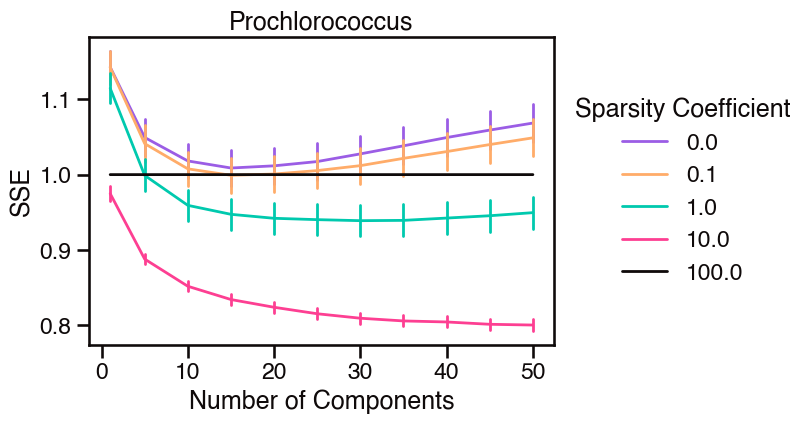

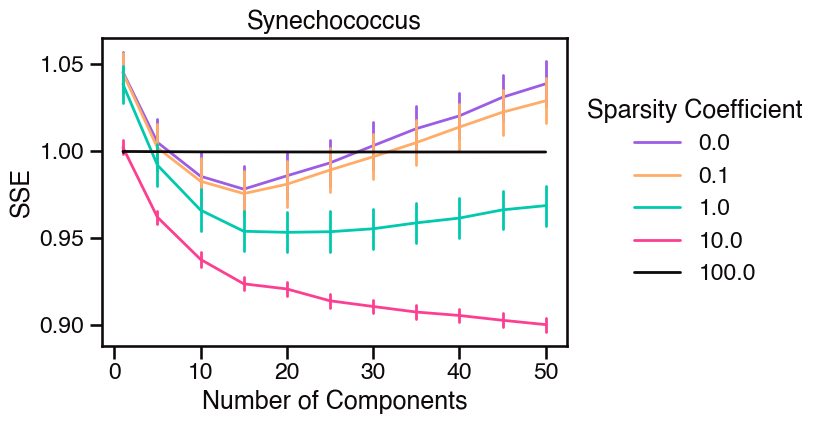

In [4]:
# look at relative_sse vs rank

for cyano in ['pro', 'syn']:
    # define data
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['bootstrap_id'].isin(range(10))]
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])]
    plot_df = plot_df[plot_df['lambda'].isin([0., 0.1, 1., 10., 100.])]

    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        hue='Sparsity Coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis, 
    );

    plt.title({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano])
    plt.xlabel('Number of Components');
    plt.ylabel('SSE')
    plt.legend(title='Sparsity Coefficient', loc='center left', bbox_to_anchor=[1, 0.5]);
    # plt.savefig(outdir / '{}-sse-v-rank.png'.format(cyano), bbox_inches='tight')


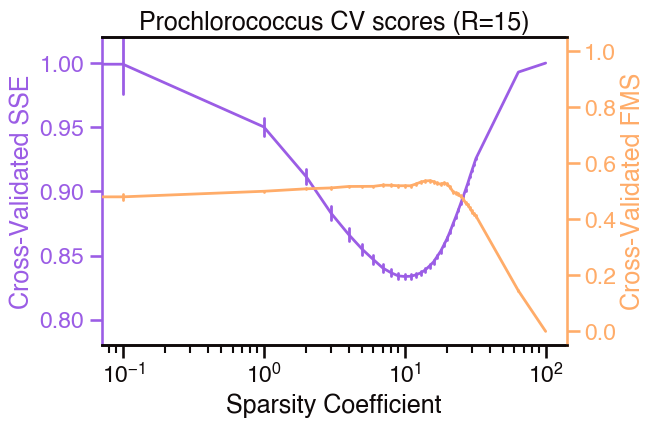

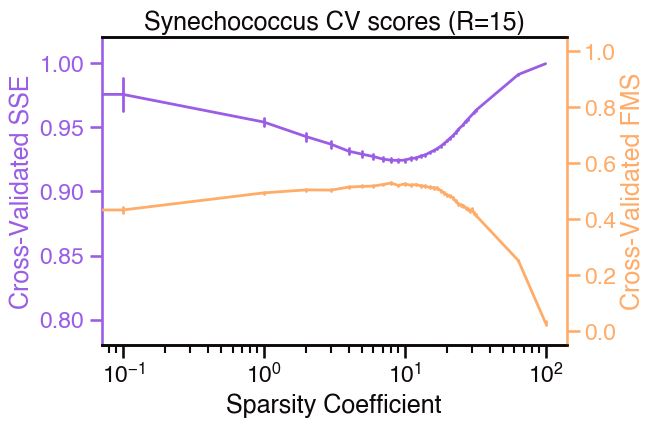

In [5]:
# look at SSE and FMS vs lambda

# define data
ranks = {'pro': 15, 'syn': 15}

for cyano in ['pro', 'syn']:
    rank = ranks[cyano]
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['rank'] == rank]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', ylabel='Cross-Validated SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
    #     style='rank', 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', ylabel='Cross-Validated FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.xscale('log');
    plt.title('{} CV scores (R={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], rank));
    # plt.savefig(outdir / '{}-cv-scores-v-lambda.png'.format(cyano), bbox_inches='tight')


# Calculate optimal parameters

In [6]:
# find rank of minimum SSE with no sparsity applied

summary_df = results_df[results_df['comparison'] == 'Cross-Validation']
summary_df = summary_df[summary_df['lambda'].isin([0.0])]
summary_df = summary_df.groupby(['genus', 'rank', 'lambda'])[['mean_gene_sparsity', 'relative_sse', 'fms_cv']].agg(
    mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
    relative_sse=('relative_sse', 'mean'), 
    fms_cv=('fms_cv', 'mean'), 
    fms_sem=('fms_cv', 'sem'), 
    bootstraps=('fms_cv', 'count')
).reset_index()

# print dataframe
summary_df.set_index(['genus', 'rank', 'lambda']).sort_values(
    ['genus', 'relative_sse'], ascending=True
).head(50)


mean_gene_sparsity  relative_sse    fms_cv   fms_sem  \
genus rank lambda                                                         
pro   15   0.0                 5023.0      1.008786  0.289331  0.016142   
      20   0.0                 5023.0      1.011689  0.236955  0.014906   
      25   0.0                 5023.0      1.017352  0.220482  0.016139   
      10   0.0                 5023.0      1.018185  0.322322  0.014977   
      30   0.0                 5023.0      1.027563  0.232678  0.012421   
      35   0.0                 5023.0      1.038295  0.236748  0.008209   
      40   0.0                 5023.0      1.049270  0.248778  0.006733   
      5    0.0                 5023.0      1.049390  0.418019  0.023182   
      45   0.0                 5023.0      1.059201  0.250387  0.004313   
      50   0.0                 5023.0      1.068558  0.248338  0.004397   
      1    0.0                 5023.0      1.142920  0.034103  0.007302   
syn   15   0.0                 6478.0      0.978135  0.290575  0.011355   
      10   0.0                 6478.0      0.985547  0.342960  0.012623   
      20   0.0                 6478.0      0.985790  0.220131  0.008580   
      25   0.0                 6478.0      0.993215  0.211081  0.007337   
      30   0.0                 6478.0      1.003078  0.192471  0.006540   
      5    0.0                 6478.0      1.005006  0.353203  0.021068   
      35   0.0                 6478.0      1.012864  0.186115  0.004455   
      40   0.0                 6478.0      1.020206  0.199077  0.005961   
      45   0.0                 6478.0      1.030892  0.185283  0.005848   
      50   0.0                 6478.0      1.038614  0.184303  0.004857   
      1    0.0                 6478.0      1.045374  0.058916  0.031281   

                   bootstraps  
genus rank lambda              
pro   15   0.0             30  
      20   0.0             30  
      25   0.0             30  
      10   0.0             30  
      30   0.0             30  
      35   0.0             30  
      40   0.0             30  
      5    0.0             30  
      45   0.0             30  
      50   0.0             30  
      1    0.0             30  
syn   15   0.0             30  
      10   0.0             30  
      20   0.0             30  
      25   0.0             30  
      30   0.0             30  
      5    0.0             30  
      35   0.0             30  
      40   0.0             30  
      45   0.0             30  
      50   0.0             30  
      1    0.0             30

In [7]:
# find sparsity corresponding to minimum CV SSE at optimal rank 

summary_df = results_df[results_df['comparison'] == 'Cross-Validation']
summary_df = summary_df[summary_df['rank'].isin([15])]
summary_df = summary_df.groupby(['genus', 'rank', 'lambda'])[['mean_gene_sparsity', 'relative_sse', 'fms_cv']].agg(
    mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
    relative_sse=('relative_sse', 'mean'), 
    fms_cv=('fms_cv', 'mean'), 
    fms_sem=('fms_cv', 'sem'), 
    bootstraps=('fms_cv', 'count')
).reset_index()

# print dataframe
summary_df.set_index(['genus', 'rank', 'lambda']).sort_values(
    ['genus', 'relative_sse'], ascending=True
    # ['genus', 'fms_cv'], ascending=[True, False]
    # ['genus', 'relative_sse'], ascending=[False, True]
).head(50)


mean_gene_sparsity  relative_sse    fms_cv   fms_sem  \
genus rank lambda                                                         
pro   15   10.0            102.083111      0.833672  0.520228  0.003339   
           11.0             88.760444      0.833882  0.519989  0.003304   
           9.0             117.829778      0.834156  0.520063  0.003251   
           12.0             77.519111      0.834919  0.526321  0.003552   
           13.0             67.909556      0.836527  0.533219  0.003258   
           8.0             137.318222      0.836591  0.521723  0.003189   
           14.0             59.676222      0.838865  0.537123  0.003305   
           7.0             162.248222      0.840228  0.522294  0.003238   
           15.0             52.624444      0.841904  0.538279  0.003290   
           16.0             46.740000      0.845010  0.534936  0.003324   
           6.0             195.724222      0.846792  0.518037  0.002899   
           17.0             41.317111      0.849315  0.528677  0.003264   
           18.0             35.869556      0.853436  0.525773  0.003405   
           5.0             241.426000      0.854810  0.517840  0.002916   
           19.0             31.894667      0.858443  0.529818  0.003334   
           20.0             27.994889      0.863321  0.525904  0.003496   
           4.0             311.190444      0.866396  0.517560  0.002758   
           21.0             25.132444      0.868840  0.514206  0.003341   
           22.0             22.452000      0.874672  0.498979  0.003407   
           23.0             19.951111      0.880008  0.493815  0.003509   
           3.0             443.276222      0.883021  0.512370  0.002419   
           24.0             17.921333      0.885394  0.490203  0.003549   
           25.0             16.185333      0.890827  0.481768  0.003564   
           26.0             14.390000      0.895987  0.473124  0.003535   
           27.0             13.029556      0.901146  0.459558  0.003790   
           28.0             11.634000      0.906176  0.452440  0.003418   
           2.0             690.028444      0.911417  0.509204  0.002387   
           29.0             10.534000      0.911506  0.440492  0.003647   
           30.0              9.415778      0.916362  0.428085  0.003854   
           31.0              8.435333      0.921029  0.419413  0.003522   
           32.0              7.666222      0.925609  0.412397  0.003509   
           1.0            1187.242444      0.950231  0.500413  0.002422   
           64.0              0.448444      0.992946  0.145284  0.002471   
           0.1            3025.655556      0.999096  0.480497  0.009901   
           100.0             0.002222      0.999994  0.000000  0.000000   
           0.0            5023.000000      1.008786  0.289331  0.016142   
syn   15   9.0             129.389111      0.924181  0.521319  0.003112   
           8.0             155.414000      0.924278  0.529767  0.003270   
           10.0            108.437111      0.924322  0.526615  0.003180   
           7.0             190.908667      0.925165  0.524491  0.003030   
           11.0             92.314222      0.925603  0.522020  0.003213   
           12.0             78.486444      0.926012  0.524390  0.003146   
           6.0             239.754222      0.927133  0.519084  0.003149   
           13.0             67.577333      0.927506  0.519974  0.003412   
           14.0             58.778667      0.928441  0.518359  0.003328   
           5.0             312.198667      0.928958  0.517817  0.003292   
           15.0             51.302667      0.930216  0.514135  0.003548   
           4.0             428.564667      0.931318  0.515282  0.003421   
           16.0             44.340889      0.931758  0.513050  0.003796   
           17.0             38.825333      0.933294  0.511561  0.003349   

                   bootstraps  
genus rank lambda              
pro   15   10.0           300  
           11.0       

In [8]:
# calculate sparsest Pro clusters within one SE of the max CV FMS (one-SE rule)

# pro max FMS
pro_best_fms = summary_df.loc[summary_df[summary_df['genus'] == 'pro'].fms_cv.idxmax(), :]
print('max CV FMS: \n\n{}\n'.format(pro_best_fms))
pro_1se_fms = pro_best_fms['fms_cv'] - pro_best_fms['fms_sem']
print('max CV FMS - 1SE: {}\n'.format(pro_1se_fms))

# show all models with at least the minimum FMS, sorted from sparsest to least sparse
summary_df[(summary_df['genus'] == 'pro') & (summary_df.fms_cv.ge(pro_1se_fms))].sort_values('lambda', ascending=False)


max CV FMS: 

genus                       pro
rank                         15
lambda                     15.0
mean_gene_sparsity    52.624444
relative_sse           0.841904
fms_cv                 0.538279
fms_sem                 0.00329
bootstraps                  300
Name: 16, dtype: object

max CV FMS - 1SE: 0.5349886931858762



,genus,rank,lambda,mean_gene_sparsity,relative_sse,fms_cv,fms_sem,bootstraps
16,pro,15,15.0,52.624444,0.841904,0.538279,0.003290,300
15,pro,15,14.0,59.676222,0.838865,0.537123,0.003305,300


In [9]:
# calculate sparsest Syn clusters within one SE of the max CV FMS (one-SE rule)

# syn max FMS
syn_best_fms = summary_df.loc[summary_df[summary_df['genus'] == 'syn'].fms_cv.idxmax(), :]
print('max CV FMS: \n\n{}\n'.format(syn_best_fms))
syn_1se_fms = syn_best_fms['fms_cv'] - syn_best_fms['fms_sem']
print('max CV FMS - 1SE: {}\n'.format(syn_1se_fms))

# show all models with at least the minimum FMS, sorted from sparsest to least sparse
summary_df[(summary_df['genus'] == 'syn') & (summary_df.fms_cv.ge(syn_1se_fms))].sort_values('lambda', ascending=False)


max CV FMS: 

genus                      syn
rank                        15
lambda                     8.0
mean_gene_sparsity     155.414
relative_sse          0.924278
fms_cv                0.529767
fms_sem                0.00327
bootstraps                 300
Name: 45, dtype: object

max CV FMS - 1SE: 0.5264974167896231



,genus,rank,lambda,mean_gene_sparsity,relative_sse,fms_cv,fms_sem,bootstraps
47,syn,15,10.0,108.437111,0.924322,0.526615,0.00318,300
45,syn,15,8.0,155.414000,0.924278,0.529767,0.00327,300


# Combined figure

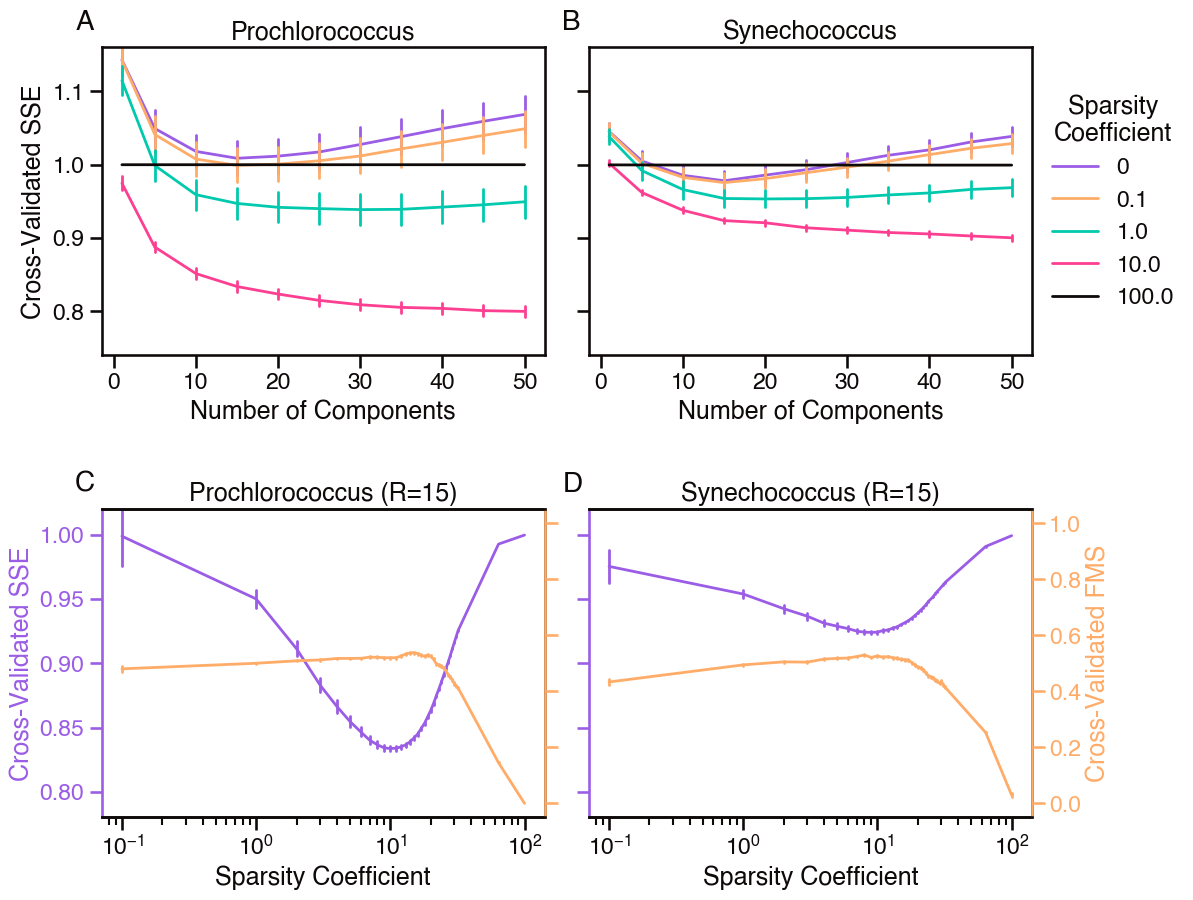

In [10]:
# combined fitting data panels

# define data to plot
r_plot_ranks = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
r_plot_lambdas = [0, 0.1, 1., 10., 100.]
l_plot_ranks = {'pro': 15, 'syn': 15}
err_style = 'bars'

# set up subplots
fig, axes = plt.subplots(
    2, 2, figsize=(12, 10), gridspec_kw={'wspace': 0.1, 'hspace': 0.5}
)
annotations = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

# iterate through cyanobacteria
for i, genus in enumerate(['pro', 'syn']):
    # set up genus data
    data_df = results_df[results_df['genus'] == genus]
    data_df = data_df[data_df['modeled_replicate'] != data_df['comparison_replicate']]
    
    # make SSE vs. rank plot
    for j, lamb in enumerate(r_plot_lambdas):
        plot_df = data_df[data_df['rank'].isin(r_plot_ranks)]
        plot_df = plot_df[plot_df['bootstrap_id'].isin(range(10))]
        plot_df = plot_df[plot_df['lambda'] == lamb]
        sns.lineplot(
            x='rank', 
            y='relative_sse', 
            color=sns.color_palette()[j], 
            errorbar='se', 
            err_style=err_style, 
            data=plot_df,
            ax=axes[0][i], 
            label=lamb, 
            legend=False
    );
    # set lables and such
    axes[0][i].annotate(annotations[i], **annot_kws)
    if i:
        axes[0][i].set(xlabel='Number of Components', ylabel=None, title='Synechococcus', ylim=[0.74, 1.16])
        axes[0][i].tick_params(labelleft=False)
        axes[0][i].legend(title='\t Sparsity\nCoefficient', alignment='center', 
                          loc='center left', bbox_to_anchor=(1, .5));
    else:
        axes[0][i].set(xlabel='Number of Components', ylabel='Cross-Validated SSE', 
                       title='Prochlorococcus', ylim=[0.74, 1.16])
        
    # make FMS & SSE vs. lambda plot
    plot_df = data_df[data_df['lambda'] != 0.0]
    plot_df = plot_df[plot_df['rank'] == l_plot_ranks[genus]]
    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    sns.lineplot(
        x='lambda', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style=err_style,
        data=plot_df, 
        ax=axes[1][i], 
        legend=False
    )
    # set lables and such
    axes[1][i].tick_params(axis='y', colors=color)
    axes[1][i].spines['left'].set_color(color)
    if i:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', xscale='log', ylabel=None)
        axes[1][i].tick_params(labelleft=False)
    else:
        axes[1][i].set(ylim=[0.78, 1.02], xlabel='Sparsity Coefficient', xscale='log', ylabel='Cross-Validated SSE')
        axes[1][i].yaxis.label.set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axes[1][i])
    sns.lineplot(
        x='lambda', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style=err_style,
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    # set lables and such
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)
    axis2.set(title='{} (R={})'.format(
        {'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], l_plot_ranks[genus]))
    axis2.annotate(annotations[2+i], **annot_kws)
    if i:
        axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', xscale='log', ylabel='Cross-Validated FMS')
        axis2.yaxis.label.set_color(color)
    else:
        axis2.set(ylim=[-.05, 1.05], xlabel='Sparsity Coefficient', xscale='log', ylabel=None)
        axis2.tick_params(labelright=False)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True
    
fig.savefig(outdir / 'pro-syn-model-fitting.png', bbox_inches='tight')


# High Rank Models

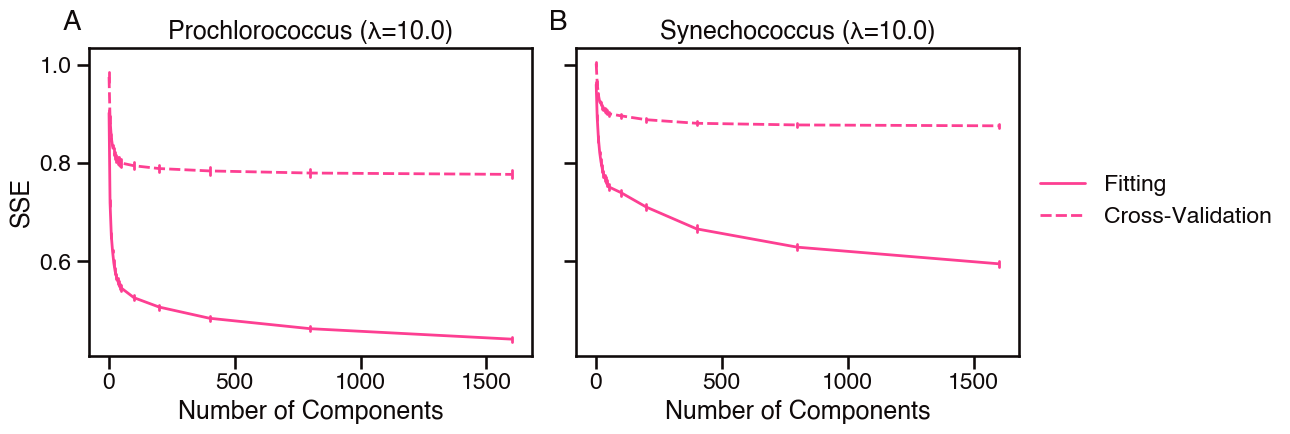

In [11]:
# look at relative_sse vs rank in high-rank models

# define data
lamb = {'pro': 10.0, 'syn': 10.0}

# set up subplots
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 4), gridspec_kw={'wspace': 0.1})
annotations = {0: 'A', 1: 'B'}
annot_kws = dict(
    xy=(-0.06, 1.08), xycoords='axes fraction', va='center', ha='left', 
    weight='bold', fontsize=20, annotation_clip=False
)

for i, genus in enumerate(['pro', 'syn']):
    # define data
    plot_df = results_df[results_df['genus'] == genus]
    plot_df = plot_df[plot_df['lambda'] == lamb[genus]]
    plot_df = plot_df[plot_df['rank'].isin([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 200, 400, 800, 1600])]

    # plot figure
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=sns.color_palette()[3], 
        style='comparison', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axes[i], 
        legend=i
    );

    # labels and such
    axes[i].annotate(annotations[i], **annot_kws)
    axes[i].set(title='{} (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[genus], lamb[genus]), 
                xlabel='Number of Components', ylabel='SSE')
    if i:
        axes[i].legend(loc='center left', bbox_to_anchor=[1, 0.5]);
    
    # save figure
    fig.savefig(outdir / 'high-rank-sse.png', bbox_inches='tight')
    

In [12]:
# look at cross-validated SSE of high-rank models

high_rank_df = results_df[results_df['comparison'] == 'Cross-Validation']
high_rank_df = high_rank_df[high_rank_df['lambda'].isin([10.0])]
high_rank_df = high_rank_df[high_rank_df['rank'].ge(50)]
high_rank_df = high_rank_df.groupby(['genus', 'rank', 'lambda'])[['mean_gene_sparsity', 'relative_sse', 'fms_cv']].agg(
    mean_gene_sparsity=('mean_gene_sparsity', 'mean'), 
    relative_sse=('relative_sse', 'mean'), 
    fms_cv=('fms_cv', 'mean'), 
    fms_sem=('fms_cv', 'sem'), 
    bootstraps=('fms_cv', 'count')
).reset_index()

# print dataframe
high_rank_df.set_index(['genus', 'rank', 'lambda']).sort_values(
    ['genus', 'relative_sse'], ascending=True
).head(50)


mean_gene_sparsity  relative_sse    fms_cv   fms_sem  \
genus rank lambda                                                         
pro   1600 10.0              1.628521      0.776961  0.304788  0.004529   
      800  10.0              3.038375      0.779704  0.257500  0.003682   
      400  10.0              6.103917      0.783980  0.231009  0.003809   
      200  10.0             11.806000      0.788814  0.234153  0.003379   
      100  10.0             22.508000      0.794492  0.307991  0.004897   
      50   10.0             41.714667      0.800007  0.423978  0.006817   
syn   1600 10.0              2.571417      0.875598  0.312177  0.003678   
      800  10.0              4.929500      0.877400  0.270090  0.002578   
      400  10.0              9.292667      0.880777  0.231396  0.003225   
      200  10.0             15.740500      0.888020  0.212529  0.002665   
      100  10.0             27.012667      0.895869  0.256357  0.004349   
      50   10.0             50.650000      0.900347  0.418962  0.006390   

                   bootstraps  
genus rank lambda              
pro   1600 10.0            30  
      800  10.0            30  
      400  10.0            30  
      200  10.0            30  
      100  10.0            30  
      50   10.0            30  
syn   1600 10.0            30  
      800  10.0            30  
      400  10.0            30  
      200  10.0            30  
      100  10.0            30  
      50   10.0            30

# Other plots

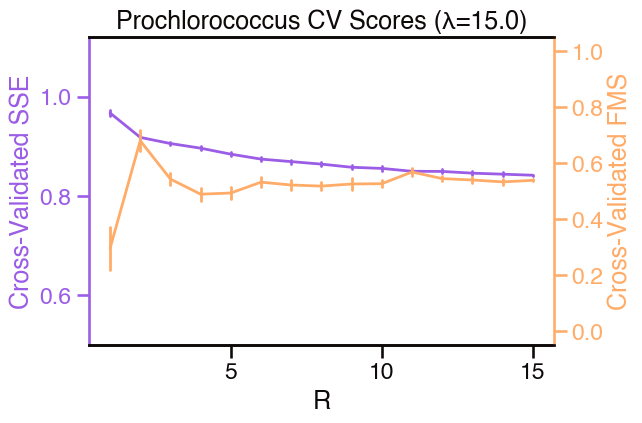

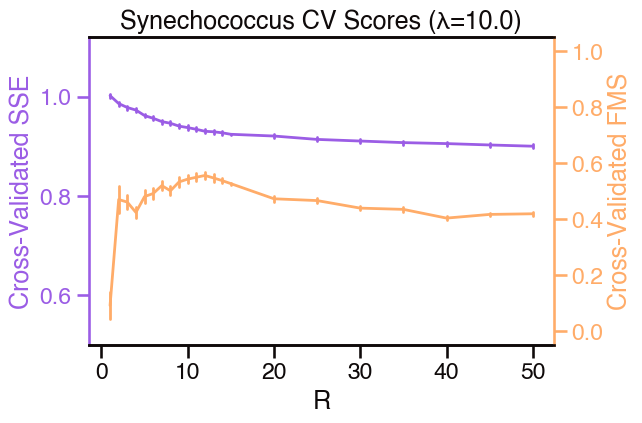

In [13]:
# look at SSE and FMS vs rank

# define data
lamb = {'pro': 15.0, 'syn': 10.0}
rank_lim = 50

for cyano in ['pro', 'syn']:
    
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Cross-Validation']
    plot_df = plot_df[plot_df['lambda'] == lamb[cyano]]
    plot_df = plot_df[plot_df['rank'].le(rank_lim)]

    # plot SSE
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.right'] = False
    color = sns.color_palette()[0]
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='relative_sse', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis, 
        legend=False
    )
    axis.set(ylim=[0.5, 1.12], xlabel='R', ylabel='Cross-Validated SSE')
    axis.yaxis.label.set_color(color)
    axis.tick_params(axis='y', colors=color)
    axis.spines['left'].set_color(color)

    # plot FMS
    color = sns.color_palette()[1]
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = False
    axis2 = plt.twinx(axis)
    sns.lineplot(
        x='rank', 
        y='fms_cv', 
        color=color, 
        errorbar='se', 
        err_style='bars',
        data=plot_df, 
        ax=axis2, 
        legend=False
    )
    axis2.set(ylim=[-.05, 1.05], xlabel='R', ylabel='Cross-Validated FMS')
    axis2.yaxis.label.set_color(color)
    axis2.tick_params(axis='y', colors=color)
    axis2.spines['right'].set_color(color)

    # put defaults back where you found them
    mpl.rcParams['axes.spines.right'] = True
    mpl.rcParams['axes.spines.left'] = True

    # fix x axis stuff
    plt.title('{} CV Scores (λ={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], lamb[cyano]));
    # plt.savefig(outdir / '{}-cv-scores-v-rank.png'.format(cyano), bbox_inches='tight')


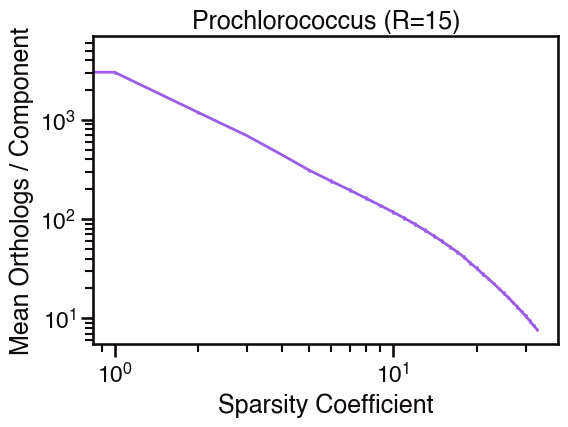

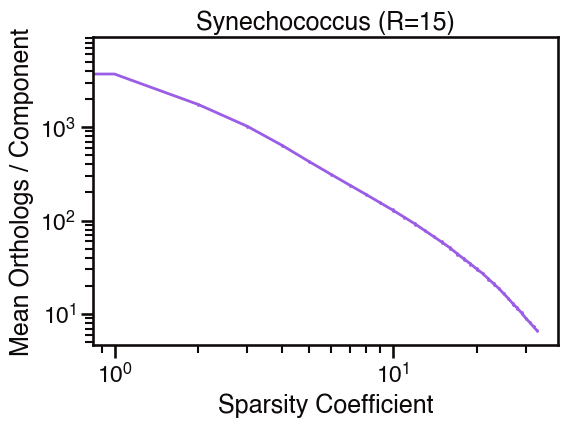

In [14]:
# look at number of nonzero components with sparsity

# define data
ranks = 15
max_lambda = 32.0
for i, cyano in enumerate(['pro', 'syn']):
    # pull data together
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Fitting']
    plot_df = plot_df[plot_df['rank'].eq(ranks)]
    plot_df = plot_df[plot_df['lambda'].le(max_lambda)]
    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='Sparsity Coefficient', 
        y='mean_gene_sparsity', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        ax=axis
    );
    # fix axes and stuff
    axis.set(
        ylabel='Mean Orthologs / Component', xscale='log', yscale='log', 
        title='{} (R={})'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano], rank)
    )
    # plt.savefig(outdir / '{}-ncomponents-v-rank.png'.format(cyano), bbox_inches='tight')


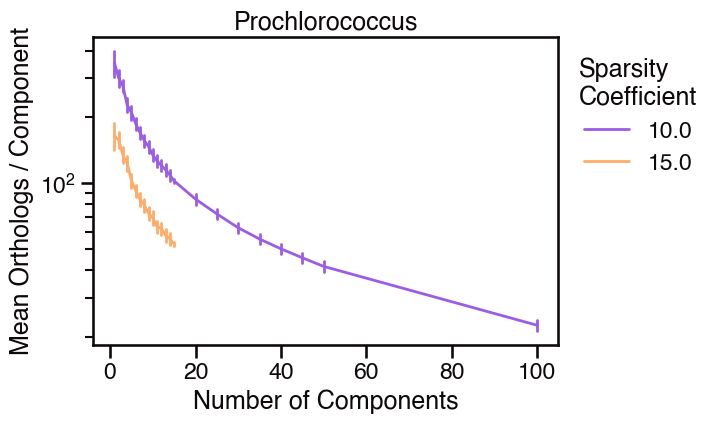

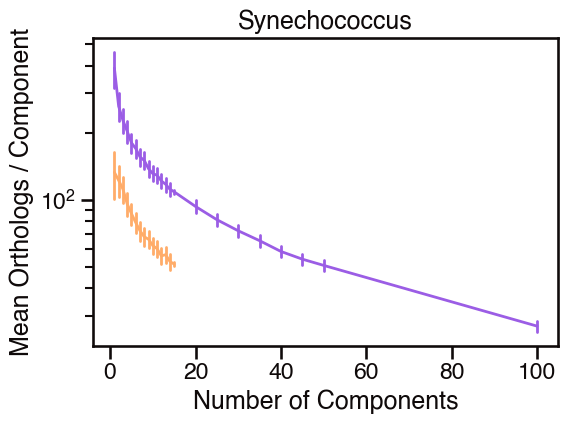

In [15]:
# look at number of nonzero components with rank

# define data
lambs = [10.0, 15.0]
rank_lim = 100

for i, cyano in enumerate(['pro', 'syn']):
    # pull data together
    plot_df = results_df[results_df['genus'] == cyano]
    plot_df = plot_df[plot_df['comparison'] == 'Fitting']
    plot_df = plot_df[plot_df['lambda'].isin(lambs)]
    plot_df = plot_df[plot_df['rank'].le(rank_lim)]
    
    # plot figure
    fig, axis = plt.subplots(figsize=(6, 4))
    sns.lineplot(
        x='rank', 
        y='mean_gene_sparsity', 
        hue='Sparsity Coefficient', 
        errorbar='se', 
        err_style='bars', 
        data=plot_df,
        legend=(not i), 
        ax=axis
    );
    # fix axes and stuff
    axis.set(
        xlabel='Number of Components', ylabel='Mean Orthologs / Component', yscale='log', 
        title='{}'.format({'pro': 'Prochlorococcus', 'syn': 'Synechococcus'}[cyano])
    )
    if not i:
        axis.legend(title='Sparsity\nCoefficient', loc='upper left', bbox_to_anchor=(1, 1))
    # plt.savefig(outdir / '{}-ncomponents-v-rank.png'.format(cyano), bbox_inches='tight')
    